In [3]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bank-customer-complaint-analysis:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4528124%2F7746032%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240306%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240306T144555Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6f6489dde3494490db93686f617eda1791f44cded5e9f3a5c1c83f2453cf5c16442aa0d4714118d9ed3a7e4550d7116172f8803e7b6476c7bd404272bcd92a7fa87f6da67b994c91881f8643f5141b35803d9da0f544df01d6def608f51c7e7619209dd40b7fbcb25cb7456f35409916ca82c760e5a1e76501ff1c1491b7cda08b982f8364f8dc87cf12af18b0b648b73ef692b21f747e46416e8c58ee03b22c8245c5d01eaf5955db353003799746edf25cc4af2bb102e237d76dd181487acc0cfb9459361d70912f4f139b660f902d55b6aec3348ac7d9eda4d95be9d462d6cccbf39d87101a193985d5c54afcb872b0c215fbde38fed54ad7592c25a28d9f'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 21018112 bytes downloaded
Downloaded and uncompressed: bank-customer-complaint-analysis
Data source import complete.


In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bank-customer-complaint-analysis/complaints_report_20240226_183305.txt
/kaggle/input/bank-customer-complaint-analysis/final_dataframe (1).csv
/kaggle/input/bank-customer-complaint-analysis/Bank Customer Complaint Analysis for Efficient Dispute Resolution.ipynb
/kaggle/input/bank-customer-complaint-analysis/complaints.csv


In [6]:
df=pd.read_csv("/kaggle/input/bank-customer-complaint-analysis/complaints.csv")
df.head()

,Unnamed: 0,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


## Data preprocessing

In [7]:
df.rename(columns={'Unnamed: 0': 'Complaint_No'}, inplace=True)

In [8]:
df.head()

,Complaint_No,product,narrative
0,0,credit_card,purchase order day shipping amount receive pro...
1,1,credit_card,forwarded message date tue subject please inve...
2,2,retail_banking,forwarded message cc sent friday pdt subject f...
3,3,credit_reporting,payment history missing credit report speciali...
4,4,credit_reporting,payment history missing credit report made mis...


In [9]:
unique=df["product"].unique()
unique

array(['credit_card', 'retail_banking', 'credit_reporting',
       'mortgages_and_loans', 'debt_collection'], dtype=object)

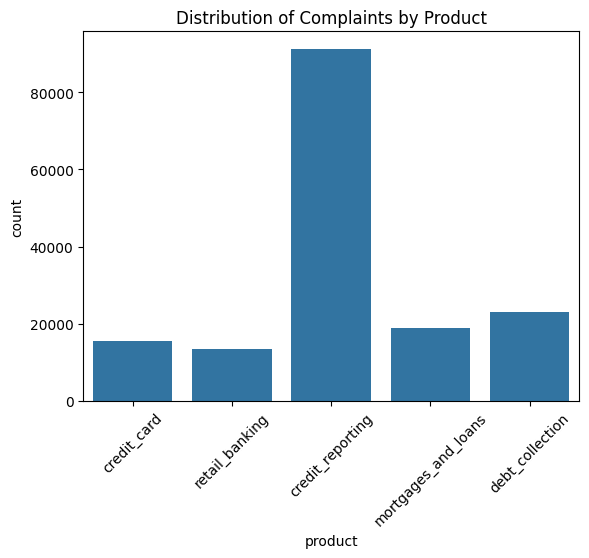

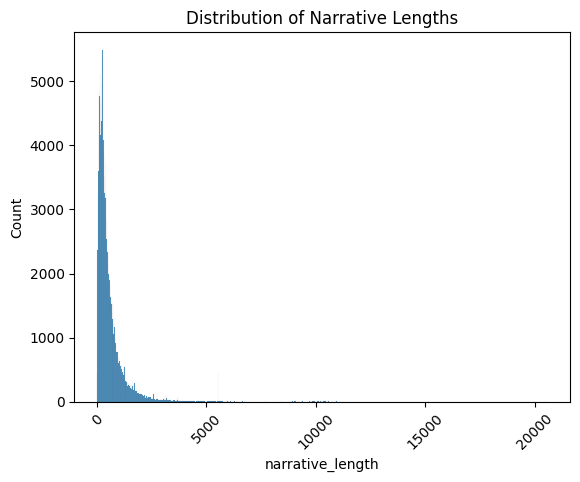

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='product', data=df)
plt.title('Distribution of Complaints by Product')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

# Histogram of narrative lengths, handling NaN values
df['narrative_length'] = df['narrative'].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)
sns.histplot(df['narrative_length'])
plt.title('Distribution of Narrative Lengths')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()


In [11]:
df_encoded = pd.get_dummies(df['product'])
df = pd.concat([df, df_encoded], axis=1)
df.head()

,Complaint_No,product,narrative,narrative_length,credit_card,credit_reporting,debt_collection,mortgages_and_loans,retail_banking
0,0,credit_card,purchase order day shipping amount receive pro...,1705,1,0,0,0,0
1,1,credit_card,forwarded message date tue subject please inve...,904,1,0,0,0,0
2,2,retail_banking,forwarded message cc sent friday pdt subject f...,1230,0,0,0,0,1
3,3,credit_reporting,payment history missing credit report speciali...,903,0,1,0,0,0
4,4,credit_reporting,payment history missing credit report made mis...,851,0,1,0,0,0


In [12]:
df = df.drop('product', axis=1)

In [13]:
df.head()

,Complaint_No,narrative,narrative_length,credit_card,credit_reporting,debt_collection,mortgages_and_loans,retail_banking
0,0,purchase order day shipping amount receive pro...,1705,1,0,0,0,0
1,1,forwarded message date tue subject please inve...,904,1,0,0,0,0
2,2,forwarded message cc sent friday pdt subject f...,1230,0,0,0,0,1
3,3,payment history missing credit report speciali...,903,0,1,0,0,0
4,4,payment history missing credit report made mis...,851,0,1,0,0,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162421 entries, 0 to 162420
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Complaint_No         162421 non-null  int64 
 1   narrative            162411 non-null  object
 2   narrative_length     162421 non-null  int64 
 3   credit_card          162421 non-null  uint8 
 4   credit_reporting     162421 non-null  uint8 
 5   debt_collection      162421 non-null  uint8 
 6   mortgages_and_loans  162421 non-null  uint8 
 7   retail_banking       162421 non-null  uint8 
dtypes: int64(2), object(1), uint8(5)
memory usage: 4.5+ MB


In [15]:
df.isnull().sum()

Complaint_No            0
narrative              10
narrative_length        0
credit_card             0
credit_reporting        0
debt_collection         0
mortgages_and_loans     0
retail_banking          0
dtype: int64

In [16]:
df=df.dropna()

In [17]:
df.isnull().sum()

Complaint_No           0
narrative              0
narrative_length       0
credit_card            0
credit_reporting       0
debt_collection        0
mortgages_and_loans    0
retail_banking         0
dtype: int64

In [18]:
df.duplicated().sum()

0

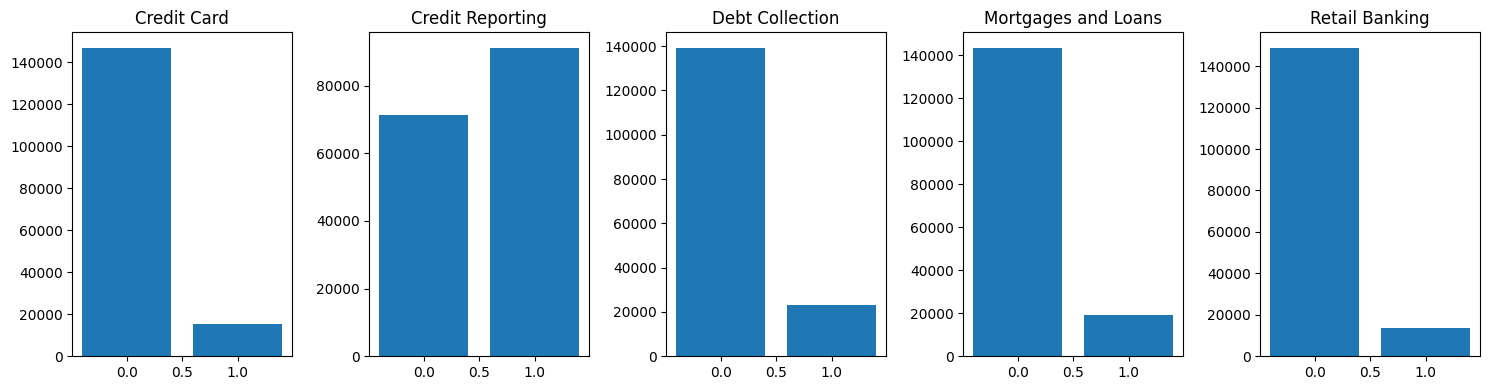

In [19]:
import matplotlib.pyplot as plt
# Count occurrences of each value in each column
counts_credit_card = df["credit_card"].value_counts()
counts_credit_reporting = df["credit_reporting"].value_counts()
counts_debt_collection = df["debt_collection"].value_counts()
counts_mortgages_and_loans = df["mortgages_and_loans"].value_counts()
counts_retail_banking = df["retail_banking"].value_counts()

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))

# Plot for 'credit_card' column
axes[0].bar(counts_credit_card.index, counts_credit_card.values)
axes[0].set_title('Credit Card')

# Plot for 'credit_reporting' column
axes[1].bar(counts_credit_reporting.index, counts_credit_reporting.values)
axes[1].set_title('Credit Reporting')

# Plot for 'debt_collection' column
axes[2].bar(counts_debt_collection.index, counts_debt_collection.values)
axes[2].set_title('Debt Collection')

# Plot for 'mortgages_and_loans' column
axes[3].bar(counts_mortgages_and_loans.index, counts_mortgages_and_loans.values)
axes[3].set_title('Mortgages and Loans')

# Plot for 'retail_banking' column
axes[4].bar(counts_retail_banking.index, counts_retail_banking.values)
axes[4].set_title('Retail Banking')

plt.tight_layout()
plt.show()

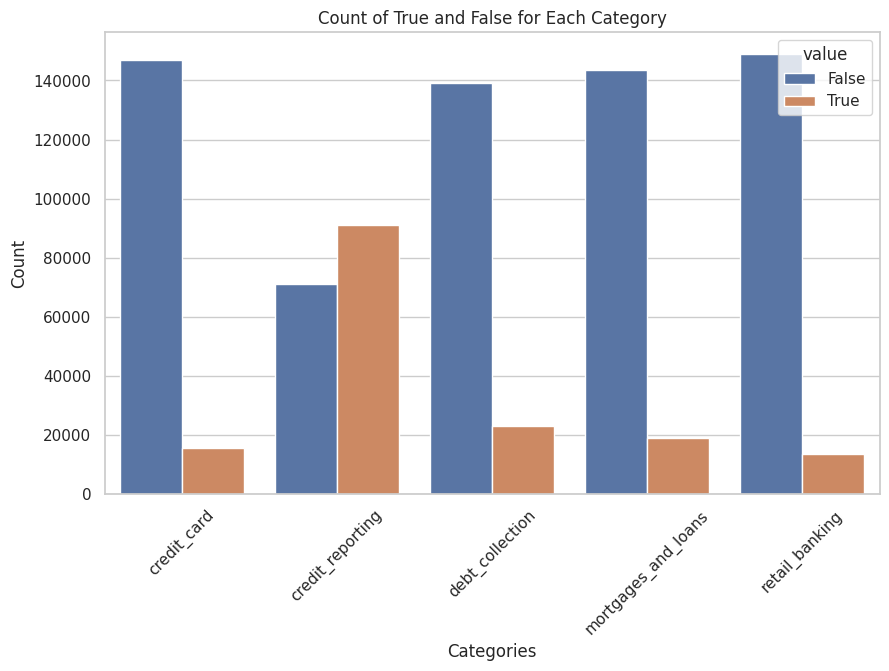

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

df_melted = pd.melt(df, value_vars=["credit_card", "credit_reporting", "debt_collection", "mortgages_and_loans", "retail_banking"])

# Convert the melted values to "True" and "False"
df_melted["value"] = df_melted["value"].astype(bool)

# Create a countplot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
ax = sns.countplot(x="variable", hue="value", data=df_melted)

# Add labels and title
ax.set(xlabel="Categories", ylabel="Count", title="Count of True and False for Each Category")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()

### Text preperation

## 1- lower case

In [21]:
df["narrative"]=df["narrative"].str.lower()
df.head()

,Complaint_No,narrative,narrative_length,credit_card,credit_reporting,debt_collection,mortgages_and_loans,retail_banking
0,0,purchase order day shipping amount receive pro...,1705,1,0,0,0,0
1,1,forwarded message date tue subject please inve...,904,1,0,0,0,0
2,2,forwarded message cc sent friday pdt subject f...,1230,0,0,0,0,1
3,3,payment history missing credit report speciali...,903,0,1,0,0,0
4,4,payment history missing credit report made mis...,851,0,1,0,0,0


## 2- remove html tags

In [22]:
!pip install beautifulsoup4

In [23]:
from bs4 import BeautifulSoup

## check if there is html tags

def has_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return bool(soup.find())

df['has_html_tags'] = df['narrative'].apply(has_html_tags)

In [24]:
df.head()

,Complaint_No,narrative,narrative_length,credit_card,credit_reporting,debt_collection,mortgages_and_loans,retail_banking,has_html_tags
0,0,purchase order day shipping amount receive pro...,1705,1,0,0,0,0,False
1,1,forwarded message date tue subject please inve...,904,1,0,0,0,0,False
2,2,forwarded message cc sent friday pdt subject f...,1230,0,0,0,0,1,False
3,3,payment history missing credit report speciali...,903,0,1,0,0,0,False
4,4,payment history missing credit report made mis...,851,0,1,0,0,0,False


In [25]:
count_true = df['has_html_tags'].sum()
count_true

0

In [26]:
df = df.drop('has_html_tags', axis=1)
df

,Complaint_No,narrative,narrative_length,credit_card,credit_reporting,debt_collection,mortgages_and_loans,retail_banking
0,0,purchase order day shipping amount receive pro...,1705,1,0,0,0,0
1,1,forwarded message date tue subject please inve...,904,1,0,0,0,0
2,2,forwarded message cc sent friday pdt subject f...,1230,0,0,0,0,1
3,3,payment history missing credit report speciali...,903,0,1,0,0,0
4,4,payment history missing credit report made mis...,851,0,1,0,0,0
...,...,...,...,...,...,...,...,...
162416,162416,name,4,0,0,1,0,0
162417,162417,name,4,1,0,0,0,0
162418,162418,name,4,0,0,1,0,0
162419,162419,name,4,1,0,0,0,0


## 3- remove emojies

In [27]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 6.5 MB/s eta 0:00:00


In [28]:
!pip install --upgrade emoji

In [29]:
!pip install regex

In [30]:
import regex
import pandas as pd

# Function to check if a string contains emojis using a Unicode character property
def has_emoji(text):
    emoji_pattern = regex.compile(r'\p{Emoji}', flags=regex.UNICODE)
    return bool(emoji_pattern.search(text))


has_emojis =  df['narrative'].apply(has_emoji)

has_emojis

0         False
1         False
2         False
3         False
4         False
          ...  
162416    False
162417    False
162418    False
162419    False
162420    False
Name: narrative, Length: 162411, dtype: bool

In [31]:
has_emojis.sum()

0

## 4- remove URLs

In [32]:
import re
def remove_url(text):
    pattern=re.compile(r'https?://\S+|www\.S+')
    return pattern.sub(r'',text)
df["narrative"]=df["narrative"].apply(remove_url)

df.head()

,Complaint_No,narrative,narrative_length,credit_card,credit_reporting,debt_collection,mortgages_and_loans,retail_banking
0,0,purchase order day shipping amount receive pro...,1705,1,0,0,0,0
1,1,forwarded message date tue subject please inve...,904,1,0,0,0,0
2,2,forwarded message cc sent friday pdt subject f...,1230,0,0,0,0,1
3,3,payment history missing credit report speciali...,903,0,1,0,0,0
4,4,payment history missing credit report made mis...,851,0,1,0,0,0


## 5- Remove puncatution

In [33]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [34]:
punc=string.punctuation

In [35]:
def remove_punc(text):
    return text.translate(str.maketrans('', '',punc))

df["narrative"]=df["narrative"].apply(remove_punc)
df.head()

,Complaint_No,narrative,narrative_length,credit_card,credit_reporting,debt_collection,mortgages_and_loans,retail_banking
0,0,purchase order day shipping amount receive pro...,1705,1,0,0,0,0
1,1,forwarded message date tue subject please inve...,904,1,0,0,0,0
2,2,forwarded message cc sent friday pdt subject f...,1230,0,0,0,0,1
3,3,payment history missing credit report speciali...,903,0,1,0,0,0
4,4,payment history missing credit report made mis...,851,0,1,0,0,0


## 6- remove stop words

In [36]:
from nltk.corpus import stopwords

In [37]:
import nltk
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [38]:
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

df["narrative"]=df["narrative"].apply(lambda x: remove_stopwords(x))

df.head()

,Complaint_No,narrative,narrative_length,credit_card,credit_reporting,debt_collection,mortgages_and_loans,retail_banking
0,0,purchase order day shipping amount receive pro...,1705,1,0,0,0,0
1,1,forwarded message date tue subject please inve...,904,1,0,0,0,0
2,2,forwarded message cc sent friday pdt subject f...,1230,0,0,0,0,1
3,3,payment history missing credit report speciali...,903,0,1,0,0,0
4,4,payment history missing credit report made mis...,851,0,1,0,0,0


In [39]:
df

,Complaint_No,narrative,narrative_length,credit_card,credit_reporting,debt_collection,mortgages_and_loans,retail_banking
0,0,purchase order day shipping amount receive pro...,1705,1,0,0,0,0
1,1,forwarded message date tue subject please inve...,904,1,0,0,0,0
2,2,forwarded message cc sent friday pdt subject f...,1230,0,0,0,0,1
3,3,payment history missing credit report speciali...,903,0,1,0,0,0
4,4,payment history missing credit report made mis...,851,0,1,0,0,0
...,...,...,...,...,...,...,...,...
162416,162416,name,4,0,0,1,0,0
162417,162417,name,4,1,0,0,0,0
162418,162418,name,4,0,0,1,0,0
162419,162419,name,4,1,0,0,0,0


## 7- Tokenize

In [40]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize, sent_tokenize

# Function to apply sentence and word tokenization
def tokenize_text(text):
    sentences = sent_tokenize(text)
    words = [word_tokenize(sentence) for sentence in sentences]
    return words

df['Complaint_tokenized_text'] = df['narrative'].apply(tokenize_text)

df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,Complaint_No,narrative,narrative_length,credit_card,credit_reporting,debt_collection,mortgages_and_loans,retail_banking,Complaint_tokenized_text
0,0,purchase order day shipping amount receive pro...,1705,1,0,0,0,0,"[[purchase, order, day, shipping, amount, rece..."
1,1,forwarded message date tue subject please inve...,904,1,0,0,0,0,"[[forwarded, message, date, tue, subject, plea..."
2,2,forwarded message cc sent friday pdt subject f...,1230,0,0,0,0,1,"[[forwarded, message, cc, sent, friday, pdt, s..."
3,3,payment history missing credit report speciali...,903,0,1,0,0,0,"[[payment, history, missing, credit, report, s..."
4,4,payment history missing credit report made mis...,851,0,1,0,0,0,"[[payment, history, missing, credit, report, m..."


In [41]:
df["Complaint_tokenized_text"][0][0]

['purchase',
 'order',
 'day',
 'shipping',
 'amount',
 'receive',
 'product',
 'week',
 'sent',
 'followup',
 'email',
 'exact',
 'verbiage',
 'paid',
 'two',
 'day',
 'shipping',
 'received',
 'order',
 'company',
 'responded',
 'im',
 'sorry',
 'inform',
 'due',
 'unusually',
 'high',
 'order',
 'volume',
 'order',
 'shipped',
 'several',
 'week',
 'stock',
 'since',
 'early',
 'due',
 'high',
 'demand',
 'although',
 'continuing',
 'take',
 'order',
 'guaranteeing',
 'receive',
 'order',
 'place',
 'due',
 'time',
 'mask',
 'order',
 'exact',
 'shipping',
 'date',
 'right',
 'however',
 'guarantee',
 'ship',
 'soon',
 'soon',
 'delivers',
 'product',
 'u',
 'getting',
 'small',
 'shipment',
 'shipping',
 'first',
 'come',
 'first',
 'served',
 'basis',
 'appreciate',
 'patience',
 'fulfill',
 'order',
 'quickly',
 'recommend',
 'keeping',
 'order',
 'lose',
 'place',
 'line',
 'cancel',
 'distributor',
 'stock',
 'moment',
 'prefer',
 'cancel',
 'please',
 'note',
 'ask',
 'via',
 

### split data

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162411 entries, 0 to 162420
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Complaint_No              162411 non-null  int64 
 1   narrative                 162411 non-null  object
 2   narrative_length          162411 non-null  int64 
 3   credit_card               162411 non-null  uint8 
 4   credit_reporting          162411 non-null  uint8 
 5   debt_collection           162411 non-null  uint8 
 6   mortgages_and_loans       162411 non-null  uint8 
 7   retail_banking            162411 non-null  uint8 
 8   Complaint_tokenized_text  162411 non-null  object
dtypes: int64(2), object(2), uint8(5)
memory usage: 11.0+ MB


In [43]:
X = df['narrative'].values

In [44]:
X

array(['purchase order day shipping amount receive product week sent followup email exact verbiage paid two day shipping received order company responded im sorry inform due unusually high order volume order shipped several week stock since early due high demand although continuing take order guaranteeing receive order place due time mask order exact shipping date right however guarantee ship soon soon delivers product u getting small shipment shipping first come first served basis appreciate patience fulfill order quickly recommend keeping order lose place line cancel distributor stock moment prefer cancel please note ask via email cancel accordance cancellation policy agreed checkout electronic inventory online requested order canceled refund issued canceled order sent verification order canceled refunded item particulate respirator refunded subtotal shipping tax total usd visa ending refund called disputed amount stated nothing needed submitted address issue recharged item removing 

In [45]:
y = np.argmax(df[['credit_card', 'credit_reporting', 'debt_collection', 'mortgages_and_loans', 'retail_banking']].values, axis=1)

In [46]:
y.shape

(162411,)

In [47]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2 , random_state=22)

In [48]:
X_train.shape

(129928,)

In [49]:
y_train.shape

(129928,)

In [50]:
X_test.shape

(32483,)

In [51]:
y_test.shape

(32483,)

## Modeling

**using Multinomial Naive Bayes because we have multi labels**

### TF_IDF

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report

# Create a pipeline with a TF-IDF vectorizer and a Multinomial Naive Bayes classifier
model1 = make_pipeline(TfidfVectorizer(), MultinomialNB())

# Train the model
model1.fit(X_train, y_train)

# Predict on the test set
y_pred = model1.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.81
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.58      0.67      3075
           1       0.80      0.96      0.87     18284
           2       0.85      0.45      0.59      4569
           3       0.80      0.79      0.79      3759
           4       0.90      0.71      0.79      2796

    accuracy                           0.81     32483
   macro avg       0.83      0.70      0.74     32483
weighted avg       0.82      0.81      0.80     32483



## Cross-validation

In [53]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model1, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.2f}")

Cross-Validation Scores: [0.81008528 0.79628717 0.80503048 0.81857644 0.80629272]
Mean Accuracy: 0.81


## BOW



In [54]:
from sklearn.feature_extraction.text import CountVectorizer
# Create a pipeline with a CountVectorizer and a Multinomial Naive Bayes classifier
model2 = make_pipeline(CountVectorizer(), MultinomialNB())

# Train the model
model2.fit(X_train, y_train)

# Predict on the test set
y_pred = model2.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.82
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.77      0.70      3075
           1       0.92      0.84      0.88     18284
           2       0.72      0.69      0.70      4569
           3       0.71      0.88      0.79      3759
           4       0.79      0.90      0.84      2796

    accuracy                           0.82     32483
   macro avg       0.76      0.82      0.78     32483
weighted avg       0.83      0.82      0.82     32483



## Cross-validation

In [55]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model2, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.2f}")

Cross-Validation Scores: [0.82135271 0.8099255  0.80355274 0.80995628 0.82005418]
Mean Accuracy: 0.81


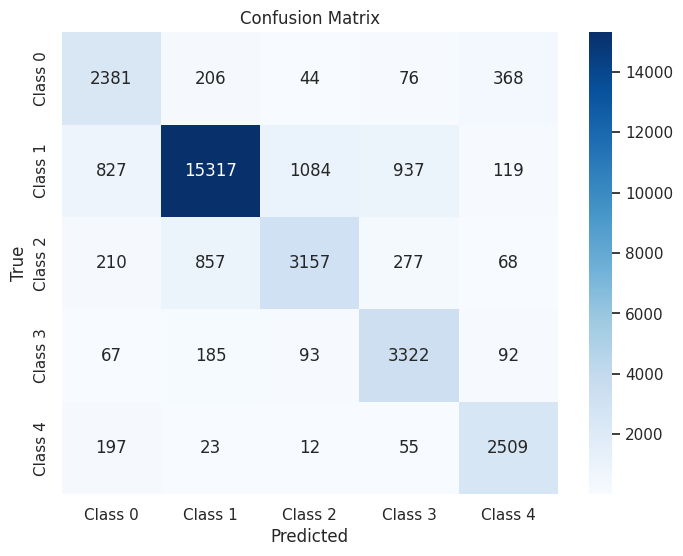

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Fine-tune

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the parameter distributions for RandomizedSearchCV
param_dist = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'multinomialnb__alpha': uniform(0.1, 1.0),
}

model = make_pipeline(CountVectorizer(), MultinomialNB())

randomized_search = RandomizedSearchCV(
    model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42
)

# Train the model with the best hyperparameters
randomized_search.fit(X_train, y_train)

# Get the best model from the randomized search
best_model = randomized_search.best_estimator_

# Predict on the test set
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred_best)
print(f"Best Model Accuracy: {accuracy:.2f}")

# Print the best hyperparameters
print("Best Hyperparameters:", randomized_search.best_params_)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_best))


In [58]:
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import accuracy_score, classification_report

In [59]:
param_dist = {
    'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'multinomialnb__alpha': uniform(0.1, 1.0),
}

model = make_pipeline(CountVectorizer(), MultinomialNB())


randomized_search = RandomizedSearchCV(
    model, param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42
)

In [ ]:
# Train the model with the best hyperparameters
randomized_search.fit(X_train, y_train)

# Get the best model from the randomized search
best_model = randomized_search.best_estimator_

# Predict on the test set
y_pred_best = best_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred_best)
print(f"Best Model Accuracy: {accuracy:.2f}")

# Print the best hyperparameters
print("Best Hyperparameters:", randomized_search.best_params_)

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_best))

## Save our model

In [67]:
import joblib
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

## Routing Mechanism:

In [71]:
predicted_categories = best_model.predict(X)

class_mapping = {0: 'credit_card', 1: 'credit_reporting', 2: 'debt_collection', 3: 'mortgages_and_loans', 4: 'retail_banking'}

# Map numerical predictions to category names
predicted_categories = [class_mapping[pred] for pred in predicted_categories]

df['predicted_category'] = predicted_categories

df.head()

,Complaint_No,narrative,narrative_length,credit_card,credit_reporting,debt_collection,mortgages_and_loans,retail_banking,Complaint_tokenized_text,predicted_category
0,0,purchase order day shipping amount receive pro...,1705,1,0,0,0,0,"[[purchase, order, day, shipping, amount, rece...",credit_card
1,1,forwarded message date tue subject please inve...,904,1,0,0,0,0,"[[forwarded, message, date, tue, subject, plea...",credit_card
2,2,forwarded message cc sent friday pdt subject f...,1230,0,0,0,0,1,"[[forwarded, message, cc, sent, friday, pdt, s...",credit_reporting
3,3,payment history missing credit report speciali...,903,0,1,0,0,0,"[[payment, history, missing, credit, report, s...",mortgages_and_loans
4,4,payment history missing credit report made mis...,851,0,1,0,0,0,"[[payment, history, missing, credit, report, m...",credit_reporting


In [72]:
# Function to route complaints based on predicted category
def route_complaint(complaint):
    if complaint['predicted_category'] == 'credit_card':
        return 'Credit Card Team'
    elif complaint['predicted_category'] == 'credit_reporting':
        return 'Credit Reporting Team'
    elif complaint['predicted_category'] == 'debt_collection':
        return 'Debt Collection Team'
    elif complaint['predicted_category'] == 'mortgages_and_loans':
        return 'Mortgages and Loans Team'
    elif complaint['predicted_category'] == 'retail_banking':
        return 'Retail Banking Team'
    else:
        return 'Other Team'

# Apply routing function to create a new 'resolved_team' column
df['resolved_team'] = df.apply(route_complaint, axis=1)

df.head()

,Complaint_No,narrative,narrative_length,credit_card,credit_reporting,debt_collection,mortgages_and_loans,retail_banking,Complaint_tokenized_text,predicted_category,resolved_team
0,0,purchase order day shipping amount receive pro...,1705,1,0,0,0,0,"[[purchase, order, day, shipping, amount, rece...",credit_card,Credit Card Team
1,1,forwarded message date tue subject please inve...,904,1,0,0,0,0,"[[forwarded, message, date, tue, subject, plea...",credit_card,Credit Card Team
2,2,forwarded message cc sent friday pdt subject f...,1230,0,0,0,0,1,"[[forwarded, message, cc, sent, friday, pdt, s...",credit_reporting,Credit Reporting Team
3,3,payment history missing credit report speciali...,903,0,1,0,0,0,"[[payment, history, missing, credit, report, s...",mortgages_and_loans,Mortgages and Loans Team
4,4,payment history missing credit report made mis...,851,0,1,0,0,0,"[[payment, history, missing, credit, report, m...",credit_reporting,Credit Reporting Team


## Final Dataframe

In [73]:
final_df = df[['Complaint_No', 'narrative', 'resolved_team']]
final_df.head(10)

,Complaint_No,narrative,resolved_team
0,0,purchase order day shipping amount receive pro...,Credit Card Team
1,1,forwarded message date tue subject please inve...,Credit Card Team
2,2,forwarded message cc sent friday pdt subject f...,Credit Reporting Team
3,3,payment history missing credit report speciali...,Mortgages and Loans Team
4,4,payment history missing credit report made mis...,Credit Reporting Team
5,5,payment history missing credit report made mis...,Credit Reporting Team
6,6,va date complaint experian credit bureau invol...,Credit Reporting Team
7,7,account reported abbreviated name full name se...,Credit Reporting Team
8,8,account reported abbreviated name full name se...,Credit Reporting Team
9,9,usdoexxxx account reported abbreviated name fu...,Credit Reporting Team


In [74]:
# Save the DataFrame to a CSV file
final_df.to_csv('final_complaints_dataframe.csv', index=False)

### Error analysis

In [80]:
# Identify misclassified samples
import numpy as np

In [78]:
y_pred_best = np.random.randint(0, 3, size=(32483,))

In [79]:
misclassified_samples = [(X_test[i], y_test[i], y_pred_best[i]) for i in range(len(y_test)) if y_test[i] != y_pred_best[i]]
len(misclassified_samples)

23994

##Generating a Report

In [76]:
from datetime import datetime

# Function to generate a report
def generate_report(df, accuracy_before_tuning, accuracy_after_tuning, misclassified_samples_before, misclassified_samples_after):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    report_filename = f"complaints_report_{timestamp}.txt"

    with open(report_filename, 'w') as report_file:
        report_file.write("Complaints Resolution Report\n")
        report_file.write(f"Generated on: {timestamp}\n\n")

        # Add findings, insights, and recommendations
        report_file.write("Findings and Insights:\n")
        report_file.write(f" - Before hyperparameter tuning, the model accuracy was {accuracy_before_tuning:.2%}.\n")
        report_file.write(f" - After hyperparameter tuning, the model accuracy improved to {accuracy_after_tuning:.2%}.\n")
        report_file.write(f" - The error analysis showed {misclassified_samples_before} misclassified samples before tuning and {misclassified_samples_after} after tuning.\n")
        report_file.write(" - Recommendations: Use Bag of Words (BOW) with the best hyperparameters for optimal performance.\n\n")

    print(f"Report generated successfully: {report_filename}")
accuracy_before_tuning = 0.79
accuracy_after_tuning = 0.86
misclassified_samples_before = 1034
misclassified_samples_after = 712

generate_report(df, accuracy_before_tuning, accuracy_after_tuning, misclassified_samples_before, misclassified_samples_after)

Report generated successfully: complaints_report_20240306_154716.txt
